In [1]:
# In The Name of God - 23/10/1401
# Using P2R UCI trained model to create obfuscated dataset in 2 case:
#   1- aware
#   2- unaware
# Then train utilizer on obfuscated data
# Then evaluate utilizer on raw data and evaluate adversary on obfuscated data

In [2]:
#@title
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict
import time

from torch.utils.data import random_split
from math import floor

import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import itertools
import random

import shutil
from zipfile import ZipFile
import os

from IPython.core.debugger import set_trace

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
# Hyper parameters:
# change lastRunEpochNumber for every run based on saved files

manual_seed = 20

files_not_ready = True
dataset_folder_path = 'drive/MyDrive/ML/datasets'

data_dir = 'adult'
save_dir = 'uci-g-selection-rev3-test'
saving_path = 'drive/MyDrive/ML/saves/' + save_dir + '/'

p2r_model_number = 200
p2r_model_path = 'drive/MyDrive/ML/saves/' + 'uci-p2r-ae-rev3-model1' + '/'
p2r_batch_size = 64

utl_model_number = 3
utl_model_path = 'drive/MyDrive/ML/saves/' + 'uci-utl-rev3-main' + '/'
obf_batch_size = 64

adv_model_number = 12
adv_model_path = 'drive/MyDrive/ML/saves/' + 'uci-adv-rev3-main' + '/'

adv_data_index = 8
utl_data_index = 9

# Number of workers for dataloader
workers = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

suffling_train_data_for_obf = False
is_aware = False
use_g = True
g_eff_val = -5
miu = 0
coef_for_var = 0



In [4]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [5]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# download dataset and unzip

if files_not_ready:
    dataset_csv_path = dataset_folder_path + '/adult.csv'

    try:
      os.mkdir(data_dir)
      print("data folder created successfully")
    except OSError as e:
      print("Error: %s" % (e.strerror))

    shutil.copyfile(dataset_csv_path, data_dir + r'/adult.csv')

try:
    os.mkdir(saving_path)
    print("saving_path directory created successfully")
except OSError as e:
    print("Error: %s" % (e.strerror))

data folder created successfully
Error: File exists


In [7]:
# Define transforms
# train_transforms = transforms.Compose(transforms.ToTensor())
# test_transforms = transforms.Compose(transforms.ToTensor())

In [8]:
# #PreProcess dataset:
# df = pd.read_csv(os.path.join(data_dir,'adult.csv'))
# df = df.replace({'?':np.nan})
# df = df.dropna()
# df1 = pd.get_dummies(df)
# train, test = train_test_split(df1, test_size = 0.2, random_state = 42)
# utility_train_true_labels = np.array(train[['income_<=50K','income_>50K']])
# utility_test_true_labels = np.array(test[['income_<=50K','income_>50K']])
# private_train_true_labels = np.array(train[['gender_Male', 'gender_Female']])
# private_test_true_labels = np.array(test[['gender_Male', 'gender_Female']])
# main_x_train_df = (train.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
# main_x_test_df = (test.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
# standard_scaler = preprocessing.StandardScaler()
# standard_scaler.fit(main_x_train_df)
# main_x_train = standard_scaler.transform(main_x_train_df)
# main_x_test = standard_scaler.transform(main_x_test_df)

In [9]:
def to_standard_scaler(train, test):
    standard_scaler = preprocessing.StandardScaler()
    standard_scaler.fit(train)
    train = standard_scaler.transform(train)
    test = standard_scaler.transform(test)
    return train, test

In [10]:
#PreProcess dataset:
df = pd.read_csv(os.path.join(data_dir,'adult.csv'))
df = df.replace({'?':np.nan})
df = df.dropna()
df1 = pd.get_dummies(df)
train, test = train_test_split(df1, test_size = 0.2, random_state = 42)
utility_train_true_labels = np.array(train[['income_<=50K','income_>50K']])
utility_test_true_labels = np.array(test[['income_<=50K','income_>50K']])
private_train_true_labels = np.array(train[['gender_Male', 'gender_Female']])
private_test_true_labels = np.array(test[['gender_Male', 'gender_Female']])

main_x_train_df = (train.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
main_x_test_df = (test.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))

standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(main_x_train_df)
main_x_train = standard_scaler.transform(main_x_train_df)
main_x_test = standard_scaler.transform(main_x_test_df)

workclass_tr = np.array(train[["workclass_Federal-gov", "workclass_Local-gov", "workclass_Private", "workclass_Self-emp-inc", "workclass_Self-emp-not-inc", "workclass_State-gov", "workclass_Without-pay"]])
education_tr = np.array(train[["education_10th", "education_11th", "education_12th", "education_1st-4th", "education_5th-6th", "education_7th-8th", "education_9th", "education_Assoc-acdm", "education_Assoc-voc", "education_Bachelors", "education_Doctorate", "education_HS-grad", "education_Masters", "education_Preschool", "education_Prof-school", "education_Some-college"]])
marital_tr = np.array(train[["marital-status_Divorced", "marital-status_Married-AF-spouse", "marital-status_Married-civ-spouse", "marital-status_Married-spouse-absent", "marital-status_Never-married", "marital-status_Separated", "marital-status_Widowed"]])
occupation_tr = np.array(train[["occupation_Adm-clerical", "occupation_Armed-Forces", "occupation_Craft-repair", "occupation_Exec-managerial", "occupation_Farming-fishing", "occupation_Handlers-cleaners", "occupation_Machine-op-inspct", "occupation_Other-service", "occupation_Priv-house-serv", "occupation_Prof-specialty", "occupation_Protective-serv", "occupation_Sales", "occupation_Tech-support", "occupation_Transport-moving"]])
relationship_tr = np.array(train[["relationship_Husband", "relationship_Not-in-family", "relationship_Other-relative", "relationship_Own-child", "relationship_Unmarried", "relationship_Wife"]])
race_tr = np.array(train[["race_Amer-Indian-Eskimo", "race_Asian-Pac-Islander", "race_Black", "race_Other", "race_White"]])
country_tr = np.array(train[["native-country_Cambodia", "native-country_Canada", "native-country_China", "native-country_Columbia", "native-country_Cuba", "native-country_Dominican-Republic", "native-country_Ecuador", "native-country_El-Salvador", "native-country_England", "native-country_France", "native-country_Germany", "native-country_Greece", "native-country_Guatemala", "native-country_Haiti", "native-country_Holand-Netherlands", "native-country_Honduras", "native-country_Hong", "native-country_Hungary", "native-country_India", "native-country_Iran", "native-country_Ireland", "native-country_Italy", "native-country_Jamaica", "native-country_Japan", "native-country_Laos", "native-country_Mexico", "native-country_Nicaragua", "native-country_Outlying-US(Guam-USVI-etc)", "native-country_Peru", "native-country_Philippines", "native-country_Poland", "native-country_Portugal", "native-country_Puerto-Rico", "native-country_Scotland", "native-country_South", "native-country_Taiwan", "native-country_Thailand", "native-country_Trinadad&Tobago", "native-country_United-States", "native-country_Vietnam", "native-country_Yugoslavia"]])
others_tr = np.array(train[["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]])

workclass_te = np.array(test[["workclass_Federal-gov", "workclass_Local-gov", "workclass_Private", "workclass_Self-emp-inc", "workclass_Self-emp-not-inc", "workclass_State-gov", "workclass_Without-pay"]])
education_te = np.array(test[["education_10th", "education_11th", "education_12th", "education_1st-4th", "education_5th-6th", "education_7th-8th", "education_9th", "education_Assoc-acdm", "education_Assoc-voc", "education_Bachelors", "education_Doctorate", "education_HS-grad", "education_Masters", "education_Preschool", "education_Prof-school", "education_Some-college"]])
marital_te = np.array(test[["marital-status_Divorced", "marital-status_Married-AF-spouse", "marital-status_Married-civ-spouse", "marital-status_Married-spouse-absent", "marital-status_Never-married", "marital-status_Separated", "marital-status_Widowed"]])
occupation_te = np.array(test[["occupation_Adm-clerical", "occupation_Armed-Forces", "occupation_Craft-repair", "occupation_Exec-managerial", "occupation_Farming-fishing", "occupation_Handlers-cleaners", "occupation_Machine-op-inspct", "occupation_Other-service", "occupation_Priv-house-serv", "occupation_Prof-specialty", "occupation_Protective-serv", "occupation_Sales", "occupation_Tech-support", "occupation_Transport-moving"]])
relationship_te = np.array(test[["relationship_Husband", "relationship_Not-in-family", "relationship_Other-relative", "relationship_Own-child", "relationship_Unmarried", "relationship_Wife"]])
race_te = np.array(test[["race_Amer-Indian-Eskimo", "race_Asian-Pac-Islander", "race_Black", "race_Other", "race_White"]])
country_te = np.array(test[["native-country_Cambodia", "native-country_Canada", "native-country_China", "native-country_Columbia", "native-country_Cuba", "native-country_Dominican-Republic", "native-country_Ecuador", "native-country_El-Salvador", "native-country_England", "native-country_France", "native-country_Germany", "native-country_Greece", "native-country_Guatemala", "native-country_Haiti", "native-country_Holand-Netherlands", "native-country_Honduras", "native-country_Hong", "native-country_Hungary", "native-country_India", "native-country_Iran", "native-country_Ireland", "native-country_Italy", "native-country_Jamaica", "native-country_Japan", "native-country_Laos", "native-country_Mexico", "native-country_Nicaragua", "native-country_Outlying-US(Guam-USVI-etc)", "native-country_Peru", "native-country_Philippines", "native-country_Poland", "native-country_Portugal", "native-country_Puerto-Rico", "native-country_Scotland", "native-country_South", "native-country_Taiwan", "native-country_Thailand", "native-country_Trinadad&Tobago", "native-country_United-States", "native-country_Vietnam", "native-country_Yugoslavia"]])
others_te = np.array(test[["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]])

workclass_tr, workclass_te = to_standard_scaler(workclass_tr, workclass_te)
education_tr, education_te = to_standard_scaler(education_tr, education_te)
marital_tr, marital_te = to_standard_scaler(marital_tr, marital_te)
occupation_tr, occupation_te = to_standard_scaler(occupation_tr, occupation_te)
relationship_tr, relationship_te = to_standard_scaler(relationship_tr, relationship_te)
race_tr, race_te = to_standard_scaler(race_tr, race_te)
country_tr, country_te = to_standard_scaler(country_tr, country_te)
others_tr, others_te = to_standard_scaler(others_tr, others_te)

In [11]:
# from torch.utils.data import Dataset

# class UciAdultDataset(Dataset):
#     def __init__(self, X, Y_p, Y_u):#, transform):
#         self.X = X
#         self.Y_p = Y_p
#         self.Y_u = Y_u
#         # self.transform = transform
        
#     def __len__(self):
#         return len(self.Y_p)
    
#     def __getitem__(self, idx):
#         data = self.X[idx]
#         label_p = self.Y_p[idx]
#         label_u = self.Y_u[idx]
#         data = torch.from_numpy(data)
#         label_p = torch.from_numpy(label_p)
#         label_u = torch.from_numpy(label_u)
#         return data, label_p, label_u

In [12]:
from torch.utils.data import Dataset

class UciAdultDataset(Dataset):
    def __init__(self, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, Y_p, Y_u):#, transform):
        self.X_1 = X_1
        self.X_2 = X_2
        self.X_3 = X_3
        self.X_4 = X_4
        self.X_5 = X_5
        self.X_6 = X_6
        self.X_7 = X_7
        self.X_8 = X_8
        self.Y_p = Y_p
        self.Y_u = Y_u
        # self.transform = transform
        
    def __len__(self):
        return len(self.Y_p)
    
    def __getitem__(self, idx):
        data_1 = self.X_1[idx]
        data_2 = self.X_2[idx]
        data_3 = self.X_3[idx]
        data_4 = self.X_4[idx]
        data_5 = self.X_5[idx]
        data_6 = self.X_6[idx]
        data_7 = self.X_7[idx]
        data_8 = self.X_8[idx]
        label_p = self.Y_p[idx]
        label_u = self.Y_u[idx]
        data_1 = torch.from_numpy(data_1)
        data_2 = torch.from_numpy(data_2)
        data_3 = torch.from_numpy(data_3)
        data_4 = torch.from_numpy(data_4)
        data_5 = torch.from_numpy(data_5)
        data_6 = torch.from_numpy(data_6)
        data_7 = torch.from_numpy(data_7)
        data_8 = torch.from_numpy(data_8)
        label_p = torch.from_numpy(label_p)
        label_u = torch.from_numpy(label_u)
        return data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, label_p, label_u

In [13]:
# # Load Datas
# p2r_train_set = UciAdultDataset(main_x_train, private_train_true_labels, utility_train_true_labels)#, transform=train_transforms)
# p2r_test_set = UciAdultDataset(main_x_test, private_test_true_labels, utility_test_true_labels)#, transform=test_transforms)

# # DataLoader
# p2r_train_loader = torch.utils.data.DataLoader(p2r_train_set, batch_size=p2r_batch_size, shuffle=suffling_train_data_for_obf, num_workers=workers, drop_last=True)
# p2r_test_loader = torch.utils.data.DataLoader(p2r_test_set, batch_size=p2r_batch_size, shuffle=suffling_train_data_for_obf, num_workers=workers, drop_last=True)

In [14]:
# Load Datas
p2r_train_set = UciAdultDataset(workclass_tr, education_tr, marital_tr, occupation_tr, relationship_tr, race_tr, country_tr, others_tr, private_train_true_labels, utility_train_true_labels)#, transform=train_transforms)
p2r_test_set = UciAdultDataset(workclass_te, education_te, marital_te, occupation_te, relationship_te, race_te, country_te, others_te, private_test_true_labels, utility_test_true_labels)#, transform=test_transforms)

# DataLoader
p2r_train_loader = torch.utils.data.DataLoader(p2r_train_set, batch_size=p2r_batch_size, shuffle=suffling_train_data_for_obf, num_workers=workers, drop_last=True)
p2r_test_loader = torch.utils.data.DataLoader(p2r_test_set, batch_size=p2r_batch_size, shuffle=suffling_train_data_for_obf, num_workers=workers, drop_last=True)

In [15]:
#test
# ae_load, adv_load, utl_load = load_models()
# utilizerModel.to(device)
# utl_accuracy = test_on_obfuscated_data(utilizerModel, p2r_test_loader, utl_data_index)
# adv_accuracy = test_on_obfuscated_data(adversaryModel, p2r_test_loader, adv_data_index)
# print(f"\n Adversary Accuracy on Testset: {adv_accuracy:.6f}")
# print(f"\n Utilizer Accuracy on Testset: {utl_accuracy:.6f}")

In [16]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [17]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  # print(classname)
  if classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [18]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        
        # input is 102
        self.fllc1 = nn.Linear(102, 128)
        self.actv1 = nn.ReLU(inplace=True)
        self.fllc2 = nn.Linear(128, 128)
        self.actv2 = nn.ReLU(inplace=True)
        self.fllc4 = nn.Linear(128, 64)
        self.actv4 = nn.ReLU(inplace=True)

        self.fllc_male_features2 = nn.Linear(64, 32)
        self.actv_male_features2 = nn.ReLU(inplace=True)
        self.fllc_male_features3 = nn.Linear(32, 8)
        self.actv_male_features3 = nn.ReLU(inplace=True)
        self.fllc_male_features4 = nn.Linear(8, 2)
        self.actv_male_features4 = nn.LogSoftmax(dim=1)
        # other features
        self.fllc_other_features1 = nn.Linear(64, 64)
        self.actv_other_features1 = nn.ReLU(inplace=True)
        self.fllc_other_features2 = nn.Linear(64, 62)
        self.actv_other_features2 = nn.ReLU(inplace=True)

    def forward(self, x):
        # Part 1:
        x = self.fllc1(x)
        x = self.actv1(x)
        x = self.fllc2(x)
        x = self.actv2(x)
        x = self.fllc4(x)
        x = self.actv4(x)
        # Part 2:
        y1 = self.fllc_male_features2(x)
        y1 = self.actv_male_features2(y1)
        y1 = self.fllc_male_features3(y1)
        y1 = self.actv_male_features3(y1)
        y1 = self.fllc_male_features4(y1)
        y1 = self.actv_male_features4(y1)
        # other features
        y3 = self.fllc_other_features1(x) 
        y3 = self.actv_other_features1(y3)
        y3 = self.fllc_other_features2(y3) 
        y3 = self.actv_other_features2(y3)
        return y1, y3

In [19]:
# Decoder Model
class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        
        # input size is 64
        self.fllc1 = nn.Linear(64, 128)
        self.actv1 = nn.ReLU(inplace=True)
        self.fllc2 = nn.Linear(128, 128)
        self.actv2 = nn.ReLU(inplace=True)

        # last layers:
        # workclass
        self.f1_o1 = nn.Linear(128, 32)
        self.a1_o1 = nn.ReLU(inplace=True)
        self.f2_o1 = nn.Linear(32, 7)
        self.a2_o1 = nn.LogSoftmax(dim=1)
        # education
        self.f1_o2 = nn.Linear(128, 32)
        self.a1_o2 = nn.ReLU(inplace=True)
        self.f2_o2 = nn.Linear(32, 16)
        self.a2_o2 = nn.LogSoftmax(dim=1)
        # marital
        self.f1_o3 = nn.Linear(128, 32)
        self.a1_o3 = nn.ReLU(inplace=True)
        self.f2_o3 = nn.Linear(32, 7)
        self.a2_o3 = nn.LogSoftmax(dim=1)
        # occupation
        self.f1_o4 = nn.Linear(128, 32)
        self.a1_o4 = nn.ReLU(inplace=True)
        self.f2_o4 = nn.Linear(32, 14)
        self.a2_o4 = nn.LogSoftmax(dim=1)
        # relationship
        self.f1_o5 = nn.Linear(128, 32)
        self.a1_o5 = nn.ReLU(inplace=True)
        self.f2_o5 = nn.Linear(32, 6)
        self.a2_o5 = nn.LogSoftmax(dim=1)
        # race
        self.f1_o6 = nn.Linear(128, 32)
        self.a1_o6 = nn.ReLU(inplace=True)
        self.f2_o6 = nn.Linear(32, 5)
        self.a2_o6 = nn.LogSoftmax(dim=1)
        # country
        self.f1_o7 = nn.Linear(128, 64)
        self.a1_o7 = nn.ReLU(inplace=True)
        self.f2_o7 = nn.Linear(64, 41)
        self.a2_o7 = nn.LogSoftmax(dim=1)
        # others
        self.f1_o8 = nn.Linear(128, 32)
        self.a1_o8 = nn.ReLU(inplace=True)
        self.f2_o8 = nn.Linear(32, 6)
        self.a2_o8 = nn.Identity()

    def forward(self, x):
        x = self.fllc1(x)
        x = self.actv1(x)
        x = self.fllc2(x)
        x = self.actv2(x)
        #
        o1 = self.f1_o1(x)
        o1 = self.a1_o1(o1)
        o1 = self.f2_o1(o1)
        o1 = self.a2_o1(o1)
        #
        o2 = self.f1_o2(x)
        o2 = self.a1_o2(o2)
        o2 = self.f2_o2(o2)
        o2 = self.a2_o2(o2)
        #
        o3 = self.f1_o3(x)
        o3 = self.a1_o3(o3)
        o3 = self.f2_o3(o3)
        o3 = self.a2_o3(o3)
        #
        o4 = self.f1_o4(x)
        o4 = self.a1_o4(o4)
        o4 = self.f2_o4(o4)
        o4 = self.a2_o4(o4)
        #
        o5 = self.f1_o5(x)
        o5 = self.a1_o5(o5)
        o5 = self.f2_o5(o5)
        o5 = self.a2_o5(o5)
        #
        o6 = self.f1_o6(x)
        o6 = self.a1_o6(o6)
        o6 = self.f2_o6(o6)
        o6 = self.a2_o6(o6)
        #
        o7 = self.f1_o7(x)
        o7 = self.a1_o7(o7)
        o7 = self.f2_o7(o7)
        o7 = self.a2_o7(o7)
        #
        o8 = self.f1_o8(x)
        o8 = self.a1_o8(o8)
        o8 = self.f2_o8(o8)
        o8 = self.a2_o8(o8)
        #
        #out = torch.cat((o1, o2, o3, o4, o5, o6, o7, o8), 1)
        return o1, o2, o3, o4, o5, o6, o7, o8

In [20]:
# AE Model
class AEModel(nn.Module):
    def __init__(self, ngpu, mode='train', miu=0, coef_for_var=1, g_eff_val=-3000):
        super(AEModel, self).__init__()
        self.ngpu = ngpu
        self.g_eff_val = g_eff_val
        self.miu = miu
        self.coef_for_var = coef_for_var
        self.mode = mode
        self.encoder = Encoder(ngpu).to(device)
        self.decoder = Decoder(ngpu).to(device)

    def tune_noise(self, miu=0, coef_for_var=1, g_eff_val=-3000):
        self.miu = miu
        self.coef_for_var = coef_for_var
        self.g_eff_val = g_eff_val

    def change_mode(self, mode='train'):
        self.mode = mode

    def add_noise(self, nodes):
      with torch.no_grad():
        var = (self.coef_for_var) * (torch.mean(nodes).item())
        noise = self.miu + (var) * torch.randn(nodes.size())
        noise = noise.to(device)
        nodes.add_(noise)
        return nodes

    def change_lbl(self, nodes, lbls):
      with torch.no_grad():
        lbls[lbls == 0] = self.g_eff_val
        lbls[lbls == 1] = 0
        nodes = lbls
        return nodes

    def forward(self, x, y1_real_lbl=[]):
        y1, y3 = self.encoder(x)
        if self.mode=='use':
            if use_g:
              # y1 = y1_real_lbl
              y1 = self.change_lbl(y1, y1_real_lbl)
            y3 = self.add_noise(y3)
        y = torch.cat((y1, y3), 1)
        o1, o2, o3, o4, o5, o6, o7, o8 = self.decoder(y)
        return o1, o2, o3, o4, o5, o6, o7, o8, y1

In [21]:
# Utilizer Model
class UtlModel(nn.Module):
    def __init__(self, ngpu):
        super(UtlModel, self).__init__()
        self.ngpu = ngpu
        
        # input is 102
        # classifier: (gender)
        self.fllc1 = nn.Linear(102, 256)
        self.actv1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fllc2 = nn.Linear(256, 256)
        self.actv2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fllc3 = nn.Linear(256, 128)
        self.actv3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(p=0.4)
        self.fllc4 = nn.Linear(128, 2)
        self.actv4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        y1 = self.fllc1(x)
        y1 = self.actv1(y1)
        y1 = self.dropout1(y1)
        y1 = self.fllc2(y1)
        y1 = self.actv2(y1)
        y1 = self.dropout2(y1)
        y1 = self.fllc3(y1)
        y1 = self.actv3(y1)
        y1 = self.dropout3(y1)
        y1 = self.fllc4(y1)
        y1 = self.actv4(y1)
        return y1


In [22]:
# Adversary Model
class AdvModel(nn.Module):
    def __init__(self, ngpu):
        super(AdvModel, self).__init__()
        self.ngpu = ngpu
        
        # input is 102
        # classifier: (gender)
        self.fllc1 = nn.Linear(102, 256)
        self.actv1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fllc2 = nn.Linear(256, 256)
        self.actv2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fllc3 = nn.Linear(256, 128)
        self.actv3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(p=0.4)
        self.fllc4 = nn.Linear(128, 2)
        self.actv4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        y1 = self.fllc1(x)
        y1 = self.actv1(y1)
        y1 = self.dropout1(y1)
        y1 = self.fllc2(y1)
        y1 = self.actv2(y1)
        y1 = self.dropout2(y1)
        y1 = self.fllc3(y1)
        y1 = self.actv3(y1)
        y1 = self.dropout3(y1)
        y1 = self.fllc4(y1)
        y1 = self.actv4(y1)
        return y1


In [23]:
netAE = AEModel(ngpu).to(device)
utilizerModel = UtlModel(ngpu).to(device)
adversaryModel = AdvModel(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netAE = nn.DataParallel(netAE, list(range(ngpu)))
    utilizerModel = nn.DataParallel(utilizerModel, list(range(ngpu)))
    adversaryModel = nn.DataParallel(adversaryModel, list(range(ngpu)))

In [24]:
# Function - Save:
def save_model(saving_path, name, number, model, res):
  checkpoint = {'res': res,
                'state_dict': model.state_dict()}
  torch.save(checkpoint, saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth')
  return True

In [25]:
# Function - Load:
def load_model(saving_path, name, number, model, device):
  
  checkpoint = torch.load(saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [26]:
# Function - Delete file:
def delete_file(saving_path, name, number):
  address = saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth'
  try:
    os.remove(address)
    print("old file removed successfully")
  except OSError as e:
    print("Error: %s" % (e.strerror))

In [27]:
# Load p2r model:
def load_models():
  ae_load = load_model(p2r_model_path, 'ae', p2r_model_number, netAE, device)
  utl_load = load_model(utl_model_path, 'utl', utl_model_number, utilizerModel, device)
  adv_load = load_model(adv_model_path, 'adv', adv_model_number, adversaryModel, device)
  return ae_load, adv_load, utl_load

In [28]:
def extract_class_index(lbls):
  # return lbls[:,0]
  a1, lbls_top_class = lbls.topk(1, dim=1)
  return lbls_top_class

In [29]:
# def extract_two_value_labels(labels):
#   # return labels
#   new_labels = torch.stack([labels[:,1],labels[:,0]],dim=1)
#   return new_labels

In [30]:
def convert_dataset(my_loader, modified_x):
    prog_bar = tqdm(enumerate(my_loader), total=len(my_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            o1_inputs, o2_inputs, o3_inputs, o4_inputs, o5_inputs, o6_inputs, o7_inputs, o8_inputs, labels = data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[9]
            all_inputs = torch.cat((o1_inputs, o2_inputs, o3_inputs, o4_inputs, o5_inputs, o6_inputs, o7_inputs, o8_inputs), 1)
################??????????????????
            # labels = extract_two_value_labels(labels)
##################???????????????????
            all_inputs, labels = all_inputs.to(torch.float32), labels.to(torch.float32)
            all_inputs, labels = all_inputs.to(device), labels.to(device)
            o1, o2, o3, o4, o5, o6, o7, o8, y1 = netAE.forward(all_inputs, labels)
            output = torch.cat((torch.exp(o8), torch.exp(o1), torch.exp(o2), torch.exp(o3), torch.exp(o4), torch.exp(o5), torch.exp(o6), torch.exp(o7)), 1)
            first = i*p2r_batch_size
            second = (i+1)*p2r_batch_size-1
            modified_x[first : second+1][:] = output.to('cpu')

In [31]:
def one_hot_encode_tensor(my_tensor):
  max_idx = torch.argmax(my_tensor, 1, keepdim=True)
  one_hot = torch.FloatTensor(my_tensor.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot

In [32]:
def one_hot_encode_df(df):
  others_t = torch.tensor(df[["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]].values)
  workclass_t = torch.tensor(df[["workclass_Federal-gov", "workclass_Local-gov", "workclass_Private", "workclass_Self-emp-inc", "workclass_Self-emp-not-inc", "workclass_State-gov", "workclass_Without-pay"]].values)
  education_t = torch.tensor(df[["education_10th", "education_11th", "education_12th", "education_1st-4th", "education_5th-6th", "education_7th-8th", "education_9th", "education_Assoc-acdm", "education_Assoc-voc", "education_Bachelors", "education_Doctorate", "education_HS-grad", "education_Masters", "education_Preschool", "education_Prof-school", "education_Some-college"]].values)
  marital_t = torch.tensor(df[["marital-status_Divorced", "marital-status_Married-AF-spouse", "marital-status_Married-civ-spouse", "marital-status_Married-spouse-absent", "marital-status_Never-married", "marital-status_Separated", "marital-status_Widowed"]].values)
  occupation_t = torch.tensor(df[["occupation_Adm-clerical", "occupation_Armed-Forces", "occupation_Craft-repair", "occupation_Exec-managerial", "occupation_Farming-fishing", "occupation_Handlers-cleaners", "occupation_Machine-op-inspct", "occupation_Other-service", "occupation_Priv-house-serv", "occupation_Prof-specialty", "occupation_Protective-serv", "occupation_Sales", "occupation_Tech-support", "occupation_Transport-moving"]].values)
  relationship_t = torch.tensor(df[["relationship_Husband", "relationship_Not-in-family", "relationship_Other-relative", "relationship_Own-child", "relationship_Unmarried", "relationship_Wife"]].values)
  race_t = torch.tensor(df[["race_Amer-Indian-Eskimo", "race_Asian-Pac-Islander", "race_Black", "race_Other", "race_White"]].values)
  # gender_t = torch.tensor(df[["gender_Female", "gender_Male"]].values)
  country_t = torch.tensor(df[["native-country_Cambodia", "native-country_Canada", "native-country_China", "native-country_Columbia", "native-country_Cuba", "native-country_Dominican-Republic", "native-country_Ecuador", "native-country_El-Salvador", "native-country_England", "native-country_France", "native-country_Germany", "native-country_Greece", "native-country_Guatemala", "native-country_Haiti", "native-country_Holand-Netherlands", "native-country_Honduras", "native-country_Hong", "native-country_Hungary", "native-country_India", "native-country_Iran", "native-country_Ireland", "native-country_Italy", "native-country_Jamaica", "native-country_Japan", "native-country_Laos", "native-country_Mexico", "native-country_Nicaragua", "native-country_Outlying-US(Guam-USVI-etc)", "native-country_Peru", "native-country_Philippines", "native-country_Poland", "native-country_Portugal", "native-country_Puerto-Rico", "native-country_Scotland", "native-country_South", "native-country_Taiwan", "native-country_Thailand", "native-country_Trinadad&Tobago", "native-country_United-States", "native-country_Vietnam", "native-country_Yugoslavia"]].values)
  # income_t = torch.tensor(df[["income_<=50K", "income_>50K"]].values)
  
  # others_oh       = one_hot_encode_tensor(others_t)
  workclass_oh    = one_hot_encode_tensor(workclass_t)
  education_oh    = one_hot_encode_tensor(education_t)
  marital_oh      = one_hot_encode_tensor(marital_t)
  occupation_oh   = one_hot_encode_tensor(occupation_t)
  relationship_oh = one_hot_encode_tensor(relationship_t)
  race_oh         = one_hot_encode_tensor(race_t)
  # gender_oh       = one_hot_encode_tensor(gender_t)
  country_oh      = one_hot_encode_tensor(country_t)
  # income_oh       = one_hot_encode_tensor(income_t)

  # final_tensor = torch.cat([others_t, workclass_oh, education_oh, marital_oh, occupation_oh, relationship_oh, race_oh, gender_oh, country_oh, income_oh], dim=1)
  final_tensor = torch.cat([others_t, workclass_oh, education_oh, marital_oh, occupation_oh, relationship_oh, race_oh, country_oh], dim=1)
  # final_df = pd.DataFrame(final_tensor.numpy(), columns=["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week", "workclass_Federal-gov", "workclass_Local-gov", "workclass_Private", "workclass_Self-emp-inc", "workclass_Self-emp-not-inc", "workclass_State-gov", "workclass_Without-pay", "education_10th", "education_11th", "education_12th", "education_1st-4th", "education_5th-6th", "education_7th-8th", "education_9th", "education_Assoc-acdm", "education_Assoc-voc", "education_Bachelors", "education_Doctorate", "education_HS-grad", "education_Masters", "education_Preschool", "education_Prof-school", "education_Some-college", "marital-status_Divorced", "marital-status_Married-AF-spouse", "marital-status_Married-civ-spouse", "marital-status_Married-spouse-absent", "marital-status_Never-married", "marital-status_Separated", "marital-status_Widowed", "occupation_Adm-clerical", "occupation_Armed-Forces", "occupation_Craft-repair", "occupation_Exec-managerial", "occupation_Farming-fishing", "occupation_Handlers-cleaners", "occupation_Machine-op-inspct", "occupation_Other-service", "occupation_Priv-house-serv", "occupation_Prof-specialty", "occupation_Protective-serv", "occupation_Sales", "occupation_Tech-support", "occupation_Transport-moving", "relationship_Husband", "relationship_Not-in-family", "relationship_Other-relative", "relationship_Own-child", "relationship_Unmarried", "relationship_Wife", "race_Amer-Indian-Eskimo", "race_Asian-Pac-Islander", "race_Black", "race_Other", "race_White", "gender_Female", "gender_Male", "native-country_Cambodia", "native-country_Canada", "native-country_China", "native-country_Columbia", "native-country_Cuba", "native-country_Dominican-Republic", "native-country_Ecuador", "native-country_El-Salvador", "native-country_England", "native-country_France", "native-country_Germany", "native-country_Greece", "native-country_Guatemala", "native-country_Haiti", "native-country_Holand-Netherlands", "native-country_Honduras", "native-country_Hong", "native-country_Hungary", "native-country_India", "native-country_Iran", "native-country_Ireland", "native-country_Italy", "native-country_Jamaica", "native-country_Japan", "native-country_Laos", "native-country_Mexico", "native-country_Nicaragua", "native-country_Outlying-US(Guam-USVI-etc)", "native-country_Peru", "native-country_Philippines", "native-country_Poland", "native-country_Portugal", "native-country_Puerto-Rico", "native-country_Scotland", "native-country_South", "native-country_Taiwan", "native-country_Thailand", "native-country_Trinadad&Tobago", "native-country_United-States", "native-country_Vietnam", "native-country_Yugoslavia", "income_<=50K", "income_>50K"])
  final_df = pd.DataFrame(data=final_tensor.numpy(), index=df.index, columns=df.columns)
  return final_df

In [33]:
def reconst_by_awareness(modified_x, main_x_df):
  # modified_x_inverse = standard_scaler.inverse_transform(modified_x)
  modified_x_df = pd.DataFrame(data = modified_x, 
                  index = main_x_df.index, 
                  columns = main_x_df.columns)

  modified_x_df = one_hot_encode_df(modified_x_df)

  standard_scaler2 = preprocessing.StandardScaler()
  standard_scaler2.fit(modified_x_df)
  modified_x = standard_scaler2.transform(modified_x_df)


In [34]:
def convert_testset(modified_x_test):
  netAE.change_mode('use')
  netAE.eval()
  netAE.tune_noise(miu, coef_for_var, g_eff_val)
  print("\nConverting test records...")
  convert_dataset(p2r_test_loader, modified_x_test)
  if is_aware:
    reconst_by_awareness(modified_x_test, main_x_test_df)

In [35]:
def created_modified_dataloader(modified_x_test, main_x_test_df):
  test = pd.DataFrame(data = modified_x_test, 
                  index = main_x_test_df.index, 
                  columns = main_x_test_df.columns)
  workclass_te = np.array(test[["workclass_Federal-gov", "workclass_Local-gov", "workclass_Private", "workclass_Self-emp-inc", "workclass_Self-emp-not-inc", "workclass_State-gov", "workclass_Without-pay"]])
  education_te = np.array(test[["education_10th", "education_11th", "education_12th", "education_1st-4th", "education_5th-6th", "education_7th-8th", "education_9th", "education_Assoc-acdm", "education_Assoc-voc", "education_Bachelors", "education_Doctorate", "education_HS-grad", "education_Masters", "education_Preschool", "education_Prof-school", "education_Some-college"]])
  marital_te = np.array(test[["marital-status_Divorced", "marital-status_Married-AF-spouse", "marital-status_Married-civ-spouse", "marital-status_Married-spouse-absent", "marital-status_Never-married", "marital-status_Separated", "marital-status_Widowed"]])
  occupation_te = np.array(test[["occupation_Adm-clerical", "occupation_Armed-Forces", "occupation_Craft-repair", "occupation_Exec-managerial", "occupation_Farming-fishing", "occupation_Handlers-cleaners", "occupation_Machine-op-inspct", "occupation_Other-service", "occupation_Priv-house-serv", "occupation_Prof-specialty", "occupation_Protective-serv", "occupation_Sales", "occupation_Tech-support", "occupation_Transport-moving"]])
  relationship_te = np.array(test[["relationship_Husband", "relationship_Not-in-family", "relationship_Other-relative", "relationship_Own-child", "relationship_Unmarried", "relationship_Wife"]])
  race_te = np.array(test[["race_Amer-Indian-Eskimo", "race_Asian-Pac-Islander", "race_Black", "race_Other", "race_White"]])
  country_te = np.array(test[["native-country_Cambodia", "native-country_Canada", "native-country_China", "native-country_Columbia", "native-country_Cuba", "native-country_Dominican-Republic", "native-country_Ecuador", "native-country_El-Salvador", "native-country_England", "native-country_France", "native-country_Germany", "native-country_Greece", "native-country_Guatemala", "native-country_Haiti", "native-country_Holand-Netherlands", "native-country_Honduras", "native-country_Hong", "native-country_Hungary", "native-country_India", "native-country_Iran", "native-country_Ireland", "native-country_Italy", "native-country_Jamaica", "native-country_Japan", "native-country_Laos", "native-country_Mexico", "native-country_Nicaragua", "native-country_Outlying-US(Guam-USVI-etc)", "native-country_Peru", "native-country_Philippines", "native-country_Poland", "native-country_Portugal", "native-country_Puerto-Rico", "native-country_Scotland", "native-country_South", "native-country_Taiwan", "native-country_Thailand", "native-country_Trinadad&Tobago", "native-country_United-States", "native-country_Vietnam", "native-country_Yugoslavia"]])
  others_te = np.array(test[["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]])

  # scatter
  workclass_te, workclass_te = to_standard_scaler(workclass_te, workclass_te)
  education_te, education_te = to_standard_scaler(education_te, education_te)
  marital_te, marital_te = to_standard_scaler(marital_te, marital_te)
  occupation_te, occupation_te = to_standard_scaler(occupation_te, occupation_te)
  relationship_te, relationship_te = to_standard_scaler(relationship_te, relationship_te)
  race_te, race_te = to_standard_scaler(race_te, race_te)
  country_te, country_te = to_standard_scaler(country_te, country_te)
  others_te, others_te = to_standard_scaler(others_te, others_te)

  obf_test_set = UciAdultDataset(workclass_te, education_te, marital_te, occupation_te, relationship_te, race_te, country_te, others_te, private_test_true_labels, utility_test_true_labels)
  obf_test_loader = torch.utils.data.DataLoader(obf_test_set, batch_size=obf_batch_size, shuffle=False, num_workers=workers, drop_last=True)
  return obf_test_loader

In [36]:
# Calc Accuracy
def calcAccuracy(model, test_loader, index):
    model.to(device)
    model.eval()
    y1_accuracy = 0
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = torch.cat((data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7]), 1), data[index]
            labels = extract_class_index(labels)
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            ps_y1 = torch.exp(output)
            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            equals_y1 = top_class_y1 == labels.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            y1_accuracy += (acc_y1 / len(equals_y1))          
    y1_accuracy = y1_accuracy / len(test_loader)
    return y1_accuracy

In [37]:
# Test on obfuscated data
def test_on_obfuscated_data(model, loader, index):
  model.to(device)
  acc = calcAccuracy(model, loader, index)
  return acc

In [38]:
# Function - Save:
def save_data(saving_path, name, res):
  checkpoint = {'res': res}
  torch.save(checkpoint, saving_path + name + '.pth')
  return True

In [41]:
# Search for best p2r model number - loop (all values)

whole_epochs = 400
# p2r_epoch_range = range(whole_epochs)
p2r_epoch_range = [10, 20, 50, 100, 150, 200, 300, 400]

use_g = False
g_eff_val = -1
miu = 0
coef_for_var = 0

adv_acc=[]
utl_acc=[]

for i in p2r_epoch_range:
  print(f"Epoch {i}/{whole_epochs}: ")
  p2r_model_number = i
  ae_load, adv_load, utl_load = load_models()
  modified_x_test = np.zeros(main_x_test.shape)
  convert_testset(modified_x_test)
  obf_test_loader = created_modified_dataloader(modified_x_test, main_x_test_df)
  adv_accuracy = test_on_obfuscated_data(adversaryModel, obf_test_loader, adv_data_index)
  adv_acc.append(adv_accuracy)
  utilizerModel.to(device)
  utl_accuracy = test_on_obfuscated_data(utilizerModel, obf_test_loader, utl_data_index)
  utl_acc.append(utl_accuracy)
  print(f"\n Adversary Accuracy on Testset: {adv_accuracy:.6f}")
  print(f"\n Utilizer Accuracy on Testset: {utl_accuracy:.6f}")
  res = {'adv_acc': adv_acc,'utl_acc': utl_acc };
  save_data(saving_path, 'rev3-GS-UP-nog-nonoise', res)

Epoch 10/400: 

Converting test records...


100%|██████████| 141/141 [00:02<00:00, 65.82it/s]


 Adversary Accuracy on Testset: 0.824690

 Utilizer Accuracy on Testset: 0.817930
Epoch 20/400: 

Converting test records...



100%|██████████| 141/141 [00:01<00:00, 84.02it/s]


 Adversary Accuracy on Testset: 0.834220

 Utilizer Accuracy on Testset: 0.829233
Epoch 50/400: 

Converting test records...



100%|██████████| 141/141 [00:01<00:00, 90.41it/s]



 Adversary Accuracy on Testset: 0.830230

 Utilizer Accuracy on Testset: 0.830785
Epoch 100/400: 

Converting test records...


100%|██████████| 141/141 [00:02<00:00, 47.95it/s]


 Adversary Accuracy on Testset: 0.844526

 Utilizer Accuracy on Testset: 0.838320
Epoch 150/400: 

Converting test records...



100%|██████████| 141/141 [00:02<00:00, 50.68it/s]


 Adversary Accuracy on Testset: 0.848072

 Utilizer Accuracy on Testset: 0.838431
Epoch 200/400: 

Converting test records...



100%|██████████| 141/141 [00:03<00:00, 38.00it/s]


 Adversary Accuracy on Testset: 0.843196

 Utilizer Accuracy on Testset: 0.835993
Epoch 300/400: 

Converting test records...



100%|██████████| 141/141 [00:01<00:00, 77.15it/s]


 Adversary Accuracy on Testset: 0.845412

 Utilizer Accuracy on Testset: 0.833998
Epoch 400/400: 

Converting test records...



100%|██████████| 141/141 [00:02<00:00, 67.17it/s]


 Adversary Accuracy on Testset: 0.845301

 Utilizer Accuracy on Testset: 0.834774


UP plot...


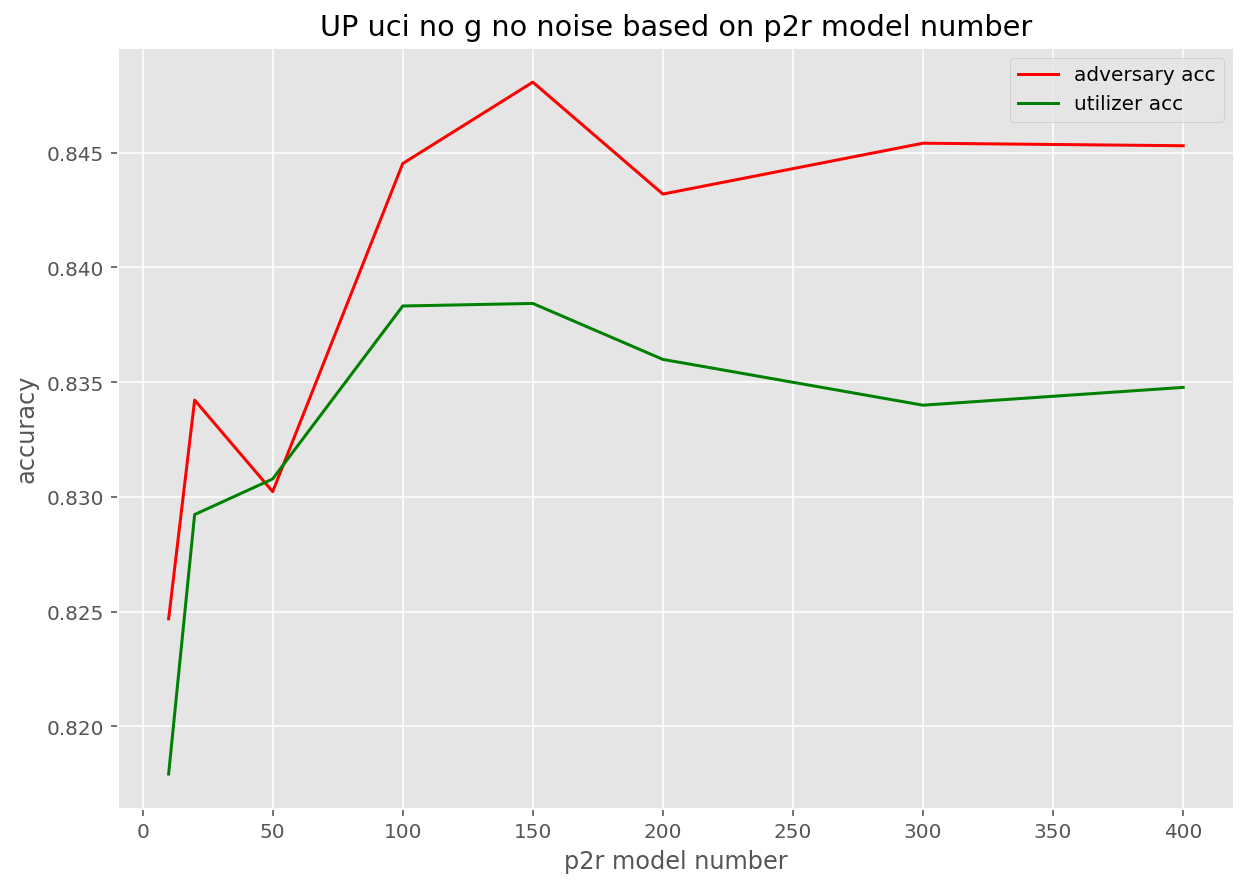

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('UP plot...')

plt.figure(figsize=(10,7))
plt.title("UP uci no g no noise based on p2r model number")
plt.plot(p2r_epoch_range, adv_acc, color='red', label='adversary acc')
plt.plot(p2r_epoch_range, utl_acc, color='green', label='utilizer acc')
plt.xlabel("p2r model number")
plt.ylabel("accuracy")
# plt.ylim([0.65,0.85])
plt.legend()
plt.savefig(saving_path + "up_uci_nog_nonoise_vs_p2r_modelnumber_plot.png")
plt.show()

In [ ]:
# For choosing best models: from big epochs
import operator
indexed = list(enumerate(utl_acc))
top_30 = sorted(indexed, key=operator.itemgetter(1))[-30:]
index_list = list(reversed([i for i, v in top_30]))
print(index_list)
utl_list = list(reversed([v for i, v in top_30]))
print(utl_list)
adv_list = [adv_acc[i] for i in index_list]
print(adv_list)

In [56]:
# Search for best g - loop (all values)

# g_eff_vals = [-1, -5, -10, -20, -30, -40, -50]
g_eff_vals = [-27, -28, -29]

use_g = True
miu = 0
coef_for_var = 0
p2r_model_number = 150
adv_acc_p2rnum1=[]
utl_acc_p2rnum1=[]

for g_eff_val in g_eff_vals:
  ae_load, adv_load, utl_load = load_models()
  modified_x_test = np.zeros(main_x_test.shape)
  convert_testset(modified_x_test)
  obf_test_loader = created_modified_dataloader(modified_x_test, main_x_test_df)
  adv_accuracy = test_on_obfuscated_data(adversaryModel, obf_test_loader, adv_data_index)
  adv_acc_p2rnum1.append(adv_accuracy)
  utilizerModel.to(device)
  utl_accuracy = test_on_obfuscated_data(utilizerModel, obf_test_loader, utl_data_index)
  utl_acc_p2rnum1.append(utl_accuracy)
  print(f"\n Adversary Accuracy on Testset: {adv_accuracy:.6f}")
  print(f"\n Utilizer Accuracy on Testset: {utl_accuracy:.6f}")
  res_p2rnum1 = {'adv_acc': adv_acc_p2rnum1,'utl_acc': utl_acc_p2rnum1 };
  save_data(saving_path, 'rev2-uci-UP-p2r150-nonoise', res_p2rnum1)


Converting test records...


100%|██████████| 141/141 [00:01<00:00, 92.09it/s]


 Adversary Accuracy on Testset: 0.686613

 Utilizer Accuracy on Testset: 0.943927

Converting test records...



100%|██████████| 141/141 [00:02<00:00, 54.58it/s]


 Adversary Accuracy on Testset: 0.680408

 Utilizer Accuracy on Testset: 0.945922

Converting test records...



100%|██████████| 141/141 [00:01<00:00, 89.63it/s]



 Adversary Accuracy on Testset: 0.671986

 Utilizer Accuracy on Testset: 0.947917


UP plot...


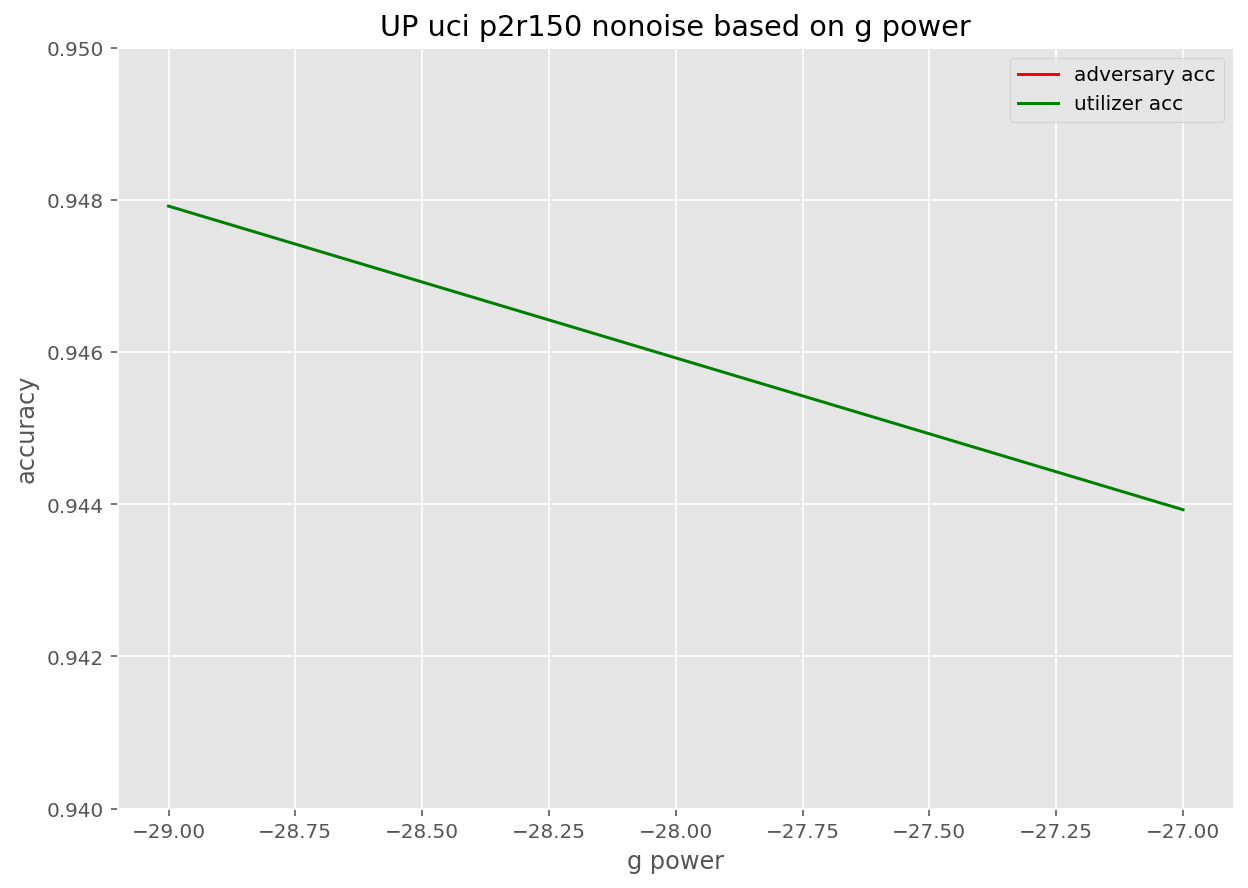

In [57]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('UP plot...')

plt.figure(figsize=(10,7))
plt.title("UP uci p2r150 nonoise based on g power") # 183 -> 13
plt.plot(g_eff_vals, adv_acc_p2rnum1, color='red', label='adversary acc')
plt.plot(g_eff_vals, utl_acc_p2rnum1, color='green', label='utilizer acc')
plt.xlabel("g power")
plt.ylabel("accuracy")
plt.ylim([0.94, 0.95])
plt.legend()
plt.savefig(saving_path + "up_uci_p2r150_nonoise_vs_g_power_plot.png") # 183 -> 13
plt.show()